# Workflow for processing Lake George field data 03MAY2018

In [1]:
import csv, glob, sys, os, re
from os import listdir
import numpy as np
import pandas as pd
import math

import datacube
from datetime import datetime, timedelta
import pyproj
from pandas import Series
import matplotlib.pyplot as plt
import matplotlib

#
# Use notebook format (allows inline zooming and moving of figures)
# Set default font size for all plots
#
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 11})

#
# Astropy is used to determine the Solar angle
#
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u

#
# dc will be used later on when comparing with satellite data:
#
dc = datacube.Datacube(app='nbart-fieldsites')

### Set up input and output directories etc

In [2]:
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/3_may_2018/'
output = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/WORKDIR/PNGS/LAG-03MAY18/'
field_site = 'Lake George'
field_date = '3/5/18'
site_number = ''
sat_name = 'Landsat 8'
suffix = 'asd.rad.txt'

#
# panel_dir and in_panel refer to the file that is used in determining the k-factor,
# so this should remain unchanged.
#
panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/'
in_panel = 'ga_panel1_jan_2018.txt'
suffix2 = 'asd.ref.sco.txt'

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'lsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'lsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'lsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'senti': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/sentinel2a_all.flt'})


#
# bad_pans    contains the names of individual panels readings that appear to be bogus
# bad_grounds contains ground-reading file names that appear to be bogus
# Use empty lists if there are no bad spectra.
#
#bad_grounds = ['site_200028.asd.rad', 'site_200029.asd.rad', 'site_2_line200030.asd.rad', 
#               'site_2_line200031.asd.rad', 'site_2_line400032.asd.rad', 'site_2_line400033.asd.rad',
#               'site_2_line800002.asd.rad', 'site_2_line200002.asd.rad', 'lkg_s2_ln10_00002.asd.rad']
bad_grounds = []
#bad_pans = []
bad_pans = ['lkg_line500038.asd.rad', 'lkg_line500039.asd.rad', 'lkg_line300000.asd.rad', 
            'lkg_line300001.asd.rad', 'lkg_line400000.asd.rad', 'lkg_line400001.asd.rad']


#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 2

### Define how to extract metadata from spectrum file headers

In [3]:
#
# Action functions are defined to retrieve specific parts of the header for each
# spectrum. These functions are used in extract_metadata.
#

# Instrument Number
def action1(l):
    return l[27:34]

# Datetime of spectrum
def action2(l):
    return l[16:38]

# SWIR1 gain
def action3(l):
    return l[15:33]

# SWIR2 gain
def action4(l):
    return l[15:33]

# GPS Latitude in decimal degrees
def action5(l):
    return float(l[17:20])-float(l[20:27])/60

# GPS Longitude in decimal degeres
def action6(l):
    return float(l[19:22])+float(l[22:30])/60


#
# Based on action functions defined above, extract header metadata from
# a file.
#
def extract_metadata(filename):
    strings = {
        'instrument number': action1,
        'Spectrum saved': action2,
        'SWIR1 gain': action3,
        'SWIR2 gain': action4,
        'GPS-Latitude': action5,
        'GPS-Longitude': action6
    }
    
    with open(filename) as file:
        list_of_actions = []
        for line in file:
            for search, action in strings.items():
                if search in line:
                    list_of_actions.append(action(line))
        return list_of_actions

### Extract spectrum and header information from a spectrum file. 
### Create a Pandas dataframe with the result.

In [4]:
def load_spectrum_to_df(infile, li):
    
    inst, date_str, swir1_go, swir2_go, lat, lon = extract_metadata(infile)

    swir1_gain = swir1_go[:3]
    swir1_offset = swir1_go[-4:]
    swir2_gain = swir2_go[:3]
    swir2_offset = swir2_go[-4:]

    date_saved = datetime.strptime(date_str, '%m/%d/%Y at %H:%M:%S')
    
    df = pd.read_csv(infile, skiprows=38, delim_whitespace=True)
    filename = df.columns[1]
    df.rename({filename: 'radiance'}, axis=1, inplace=True)
    df['filename'] = filename
    df['date_saved'] = date_saved
    df['Latitude'] = lat
    df['Longitude'] = lon
    df['Line'] = li
    df['Spec_number'] = int(filename[-10:-8])
    df['Inst_number'] = inst
    df['SWIR1_gain'] = swir1_gain
    df['SWIR1_offset'] = swir1_offset
    df['SWIR2_gain'] = swir2_gain
    df['SWIR2_offset'] = swir2_offset
    return df

### Loop through all spectrum files in "indir" and combine the resulting dataframes.

 For each 'line*' directory in 'indir', iterate through each file
 ending with 'suffix' and run 'load_spectrum_to_df'. Finally,
 return a concatenated dataframe made up of all the individual
 dataframes.


In [5]:
def load_from_dir(indir):
    all_dfs = []
    for li in range(1, len(glob.glob(indir+'line*'))+1):
        home2 = indir+'line'+str(li)+'/'

        #
        # Initalise 'spectra' list and fill with files that end in 'suffix'
        #
        spectra = []
        for root, dirs, files in sorted(os.walk(home2)):
            for file in files:
                if file.endswith(suffix):
                    spectra.append(file)
        spectra = sorted(spectra)

        for name in spectra:
            infile = home2 + name

            df = load_spectrum_to_df(infile, li)
            all_dfs.append(df)
    return pd.concat(all_dfs)

### Define 'alldata' as the dataframe that contains all the raw spectra.
Show the first wavelength of every spectrum, so that the data integrity can be checked.

In [6]:
alldata = load_from_dir(indir)

alldata[alldata['Wavelength']==350]

,Wavelength,radiance,filename,date_saved,Latitude,Longitude,Line,Spec_number,Inst_number,SWIR1_gain,SWIR1_offset,SWIR2_gain,SWIR2_offset
0,350,0.084931,lkg_line100000.asd.rad,2018-05-03 00:07:06,-35.093042,149.462487,1,0,18179/2,50,2059,34,2078
0,350,0.084871,lkg_line100001.asd.rad,2018-05-03 00:07:10,-35.093042,149.462487,1,1,18179/2,50,2059,34,2078
0,350,0.003494,lkg_line100002.asd.rad,2018-05-03 00:07:24,-35.093050,149.462467,1,2,18179/2,50,2059,34,2078
0,350,0.003469,lkg_line100003.asd.rad,2018-05-03 00:07:28,-35.093048,149.462440,1,3,18179/2,50,2059,34,2078
0,350,0.003914,lkg_line100004.asd.rad,2018-05-03 00:07:31,-35.093045,149.462402,1,4,18179/2,50,2059,34,2078
0,350,0.003787,lkg_line100005.asd.rad,2018-05-03 00:07:35,-35.093052,149.462372,1,5,18179/2,50,2059,34,2078
0,350,0.003529,lkg_line100006.asd.rad,2018-05-03 00:07:38,-35.093058,149.462328,1,6,18179/2,50,2059,34,2078
0,350,0.003908,lkg_line100007.asd.rad,2018-05-03 00:07:42,-35.093060,149.462292,1,7,18179/2,50,2059,34,2078
0,350,0.003539,lkg_line100008.asd.rad,2018-05-03 00:07:46,-35.093078,149.462260,1,8,18179/2,50,2059,34,2078
0,350,0.003924,lkg_line100009.asd.rad,2018-05-03 00:07:49,-35.093090,149.462225,1,9,18179/2,50,2059,34,2078


In [7]:
#
# Uncommenting the following line allows jupyter notebook to show more lines.
# This is needed when looking into the details of long dataframes/lists etc.
#
#pd.options.display.max_rows = 5000

### Specify which spectra are panels/ground/good/bad

 Determine panel file names by assuming that all panels have a data value of at least 0.1
 in the first wavelength (350nm). Call this dataframe 'panel_names'.

 good_panels = all panel data with bad panels removed<BR>
 bad_panels  = all bad panel data<BR>
 all_panels = both good and bad panel data<BR>
 good_grounds = good ground readings<BR>
 all_grounds = all ground data.<P>
 Any bad ground data (bad_grounds) is defined in the 2nd cell.


In [8]:
panel_names = alldata[(alldata['Wavelength']==350) & (alldata['radiance']>=0.06)]['filename']

all_panels = alldata.loc[alldata['filename'].isin(panel_names)]
good_panels = all_panels.loc[~all_panels['filename'].isin(bad_pans)]
bad_panels = alldata.loc[alldata['filename'].isin(bad_pans)]

tmp_grounds = alldata.loc[~alldata['filename'].isin(bad_grounds)]
good_grounds = tmp_grounds.loc[~tmp_grounds['filename'].isin(panel_names)]
all_grounds = alldata.loc[~alldata['filename'].isin(panel_names)]

### Make a dataframe that contains just the spectra, with one spectrum per column

 Loop over each line 'i' and then over each spectrum 'j' within line 'i'.
 
 For the first spectrum, copy both the
 Wavelength (for the index) and radiance to a new dataframe (temp2).<BR>
 For all subsequent spectra, append the new dataframe with a radiance
 column. <BR>The results in a new dataframe 'outpanel' that has a wavelength
 column (also set as the index), <BR>plus all the radiances in subsequent
 columns.



In [9]:
def make_spec_df(in_df):
    for i in in_df.Line.unique():
        temp_loop = in_df[(in_df['Wavelength']==350) & (in_df['Line']==i)]
        for j in temp_loop['Spec_number']:
            temp2 = in_df[(in_df['Spec_number']==j) & (in_df['Line']==i)]
            
            try:
                out_df['radiance'+str(i)+"-"+str(j)] = temp2['radiance']
            except UnboundLocalError:
                out_df = temp2[['Wavelength', 'radiance']].copy()

    out_df.set_index("Wavelength", inplace=True)

    return out_df

### Create dataframes for all/good/bad panel spectra.

For the bad panel spectra dataframe, first check to see if bad panels have been defined.<BR>
If not, then don't create anything.

In [10]:
all_panel_spec = make_spec_df(all_panels)
good_panel_spec = make_spec_df(good_panels)
try:
    bad_panel_spec = make_spec_df(bad_panels)
except UnboundLocalError:
    pass

## Figure 1
### Plot panel radiances for all/good/bad panels

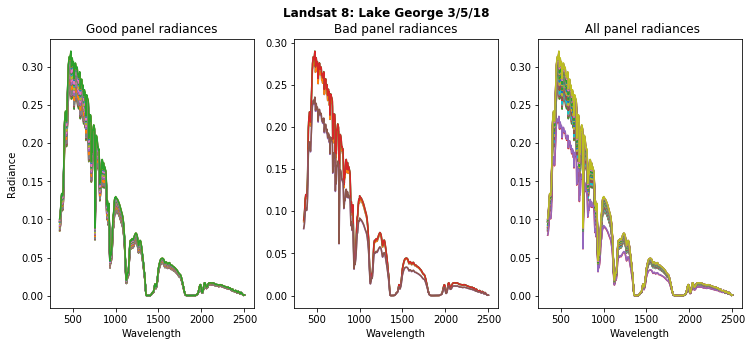

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11.0, 5.0))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number, fontweight='bold')
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

#
# Plot the radiances for the good panels.
#
good_panel_spec.plot(title = 'Good panel radiances', legend=False, ax=axes[0])
axes[0].set_ylabel("Radiance")

#
# Plot the bad panel radiances, if they exist (found in line 8)
#
try:
    bad_panel_spec.plot(title = "Bad panel radiances", legend=False, ax=axes[1])
except NameError:
    pass
#
# Plot the ALL panel radiances
#
all_panel_spec.plot(title = " All panel radiances", legend=False, ax=axes[2])

#
# Check that output directory exists, if not, create it.
#
directory = os.path.dirname(output)
if not os.path.exists(directory):
    os.makedirs(directory)

#
# Save plot to output directory.
#
plt.savefig(output+'Fig01_PanelRadiances.png')

# Figure 2

### Diagnosis plots of bad panel spectra

 Create a mean of the good panel readings, as well as the bad panel
 readings. <BR>Then a ratio and a difference of the two can be (seperately)
 created and plotted.

 Since the two bad panel readings are higher than they should be, <BR>we
 put the bad panels on the top of the division and first in the
 difference.

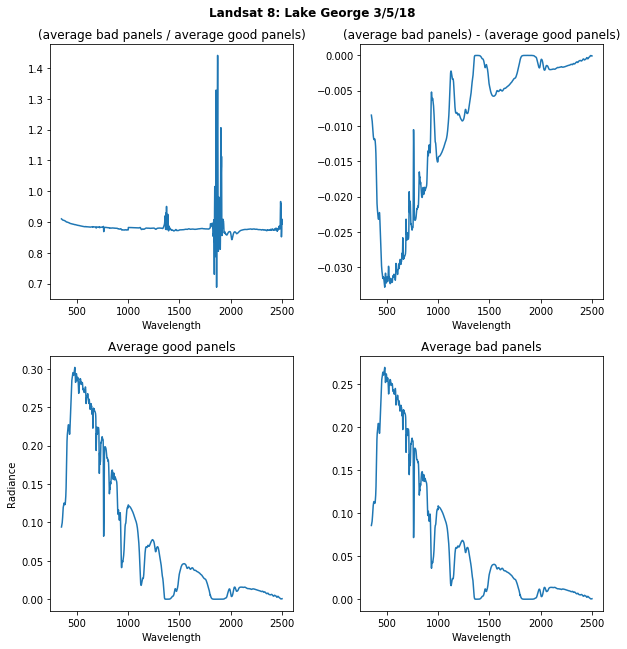

In [12]:
good_panel_mean = good_panel_spec.mean(axis=1)

try: 
    bad_panel_mean = bad_panel_spec.mean(axis=1)
    good_bad_div = bad_panel_mean.div(good_panel_mean, axis=0)
    good_bad_diff = bad_panel_mean.sub(good_panel_mean, axis=0)

    pd.Series.to_frame(good_bad_div)
    pd.Series.to_frame(good_bad_diff)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9.5, 9.5))
    fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number, fontweight='bold')

    good_bad_div.plot(title='(average bad panels / average good panels)', legend=False, ax=axes[0,0])

    good_bad_diff.plot(title='(average bad panels) - (average good panels)', legend=False, ax=axes[0,1])

    good_panel_mean.plot(title='Average good panels', legend=False, ax=axes[1,0])
    axes[1,0].set_ylabel("Radiance")
    plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

    bad_panel_mean.plot(title='Average bad panels', legend=False, ax=axes[1,1])
    plt.savefig(output+'Fig02_GoodBadPanelCompare.png')

except NameError:
    pass

### Create spectral dataframes for all ground spectra and good ground spectra

In [13]:
all_grounds_spec = make_spec_df(all_grounds)
good_grounds_spec = make_spec_df(good_grounds)

# Figure 3

### Plot ground spectra (all and good), normalised to the median good spectrum

These plots are used to identify any ground spectra that are bogus.

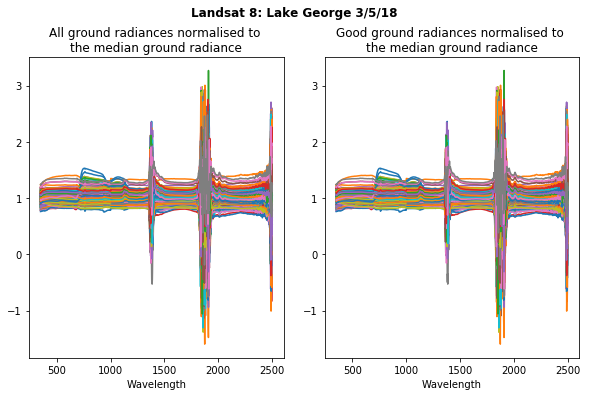

In [14]:
good_median = good_grounds_spec.median(axis=1)
good_norm = good_grounds_spec.div(good_median, axis=0)
all_norm = all_grounds_spec.div(good_median, axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9.6, 6.0))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number, fontweight='bold')
plt.tight_layout(pad=5.5, w_pad=1.0, h_pad=1.0)

all_norm.plot(title="All ground radiances normalised to \nthe median ground radiance", legend=False, ax=axes[0])

good_norm.plot(title="Good ground radiances normalised to \nthe median ground radiance", legend=False, ax=axes[1])

plt.savefig(output+'Fig03_GroundRadiances.png')

### Create dataframe with relative time stamps

 Make a new dataframe with time since the first good panel reading
 along the <BR>x-axis and "1" for the y-axis. This allows a plot of the
 data timeline to be made.


In [15]:
def make_timeline(in_df, good_panels):
    
    temp_df = in_df[['date_saved', 'Line']].loc[in_df['Wavelength']==350]
    gpt = good_panels[['date_saved', 'Line']].loc[good_panels['Wavelength']==350]
    
    out_df = temp_df.copy()
    for i in range(len(out_df)):
        out_df.iloc[[i], [0]]=(temp_df.iloc[i][0]-gpt.iloc[0][0]).seconds

    out_df['ones'] = np.ones(len(out_df))
    return out_df


### Create time-relative dataframes

gpt = good panels<BR>
gpta = all panels<BR>
adt = good grounds<BR>
adta = all grounds

In [16]:
gpt = make_timeline(good_panels, good_panels)
gpta = make_timeline(all_panels, good_panels)
adt = make_timeline(good_grounds, good_panels)
adta = make_timeline(all_grounds, good_panels)

### Create multi-panel plot function with one line plotted on each panel

Given the number of lines in the dataset, determine the best plot layout.<BR>
This assumes a single column for only a single plot,<BR>
two columns for up to four panel plots and three columns for up to 15 panel plots.

 Panel readings are coded in as blue crosses and ground readings are
 coded as orange vertical lines.


In [17]:
def panel_plot_layout(nlines):
    n=3; m=5
    if nlines < 13:
        m=4
    if nlines < 10:
        m=3
    if nlines < 9:
        n=2; m=4
    if nlines < 7:
        m=3
    if nlines < 5:
        m=2
    if nlines < 3:
        m=1
    if nlines < 2:
        n=1
    return n, m


def multi_timeline_plot(n, m, gpta, adta):
    k=0
    for i in range(m):
        for j in range(n):
            k+=1
            if k > gpta.Line.max():
                break
            elif gpta[(gpta['Line']==k)].empty:
                axes[i,j].axis('off')
            else:
                temp_loop = gpta[(gpta['Line']==k)]
                all_loop = adta[(adta['Line']==k)]
                all_loop.plot(x='date_saved', y='ones', kind='scatter', legend=False, ax=axes[i,j], color='orange', marker='|')
                temp_loop.plot(x='date_saved', y='ones', kind='scatter', legend=False, ax=axes[i,j], marker='x', sharey=True, title='line'+str(k))
                if i==m-1:
                    axes[i,j].set_xlabel("Time (seconds)")
                else:
                    axes[i,j].set_xlabel("")
                axes[i,j].set_ylabel("")
                axes[i,j].set_yticks([])
    
    if k in [2, 4, 6, 8, 12, 15]:
        axes[-1, -1].axis('off')
    if k in [11, 14]:
        axes[-1, -1].axis('off')
        axes[-1, -2].axis('off')
    #plt.tight_layout()
    
    #
    # The following commented out lines will plot an effective legend. However, they are not used
    # because it is a combination of relative and absolute coordinates, which is not easy to automate.
    #
    #plt.scatter(2465, 1.007, marker="|", c='orange')
    #plt.scatter(2465, 1.009, marker="x", c='blue')
    #plt.figtext(0.915, 0.268, "Panel")
    #plt.figtext(0.912, 0.246, "Ground")



# Figure 4

### Plot timelines for ALL panel and ground data, with one line in one panel

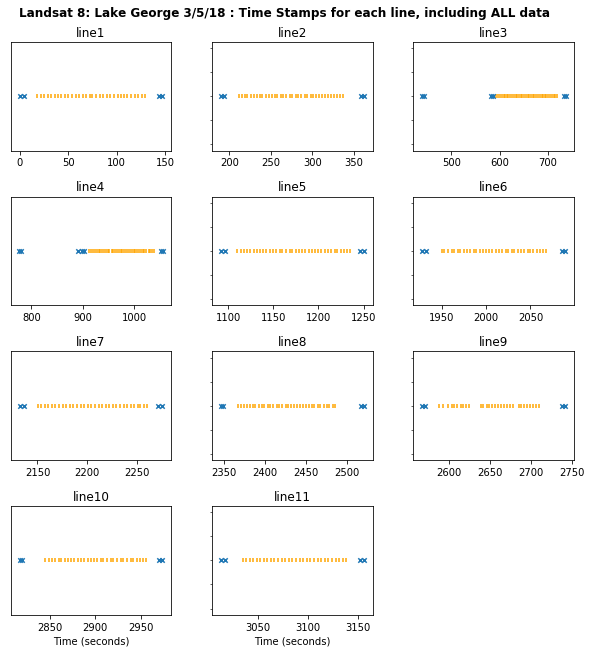

In [18]:
n, m = panel_plot_layout(len(gpta.Line.unique()))

fig, axes = plt.subplots(nrows=m, ncols=n, figsize=(9.5, 9.5))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number+': Time Stamps for each line, including ALL data', fontweight='bold')
plt.tight_layout(pad=4.5, w_pad=1.0, h_pad=2.5)

multi_timeline_plot(n, m, gpta, adta)


plt.savefig(output+'Fig04_AllTimeLineData.png')

# Figure 5

### Plot timelines for GOOD panel and ground data, with one line in one panel

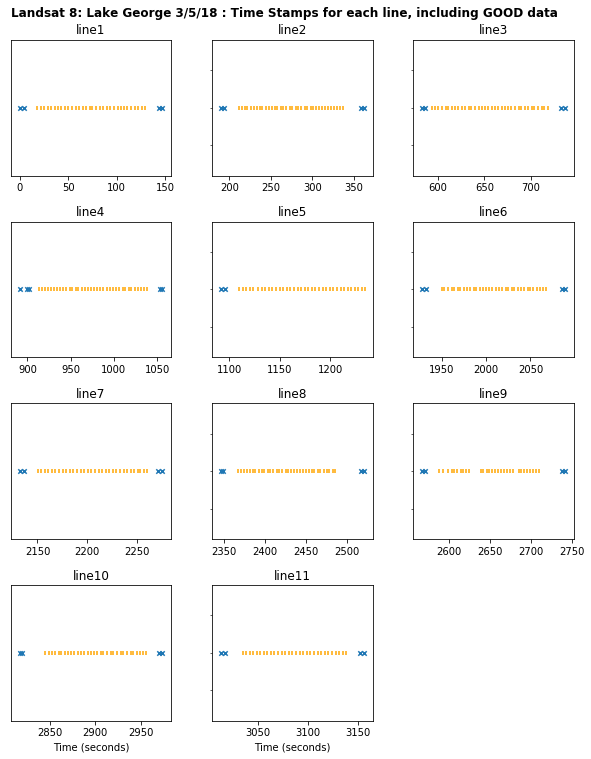

In [19]:
n, m = panel_plot_layout(len(gpta.Line.unique()))

fig, axes = plt.subplots(nrows=m, ncols=n, figsize=(9.5, 11))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number+': Time Stamps for each line, including GOOD data', fontweight='bold')
plt.tight_layout(pad=4.5, w_pad=1.0, h_pad=2.5)

multi_timeline_plot(n, m, gpt, adt)

plt.savefig(output+'Fig05_GoodTimeLineData.png')

# Figure 6

### Create timeline plot of averaged, normalised all/good panels

These plots are used to identify any panels that show unusually bright or dark readings,<BR>
    which can be weeded out as bad panels.
    
The general shape of the curve should follow "insolation" - the changing of incident light
due to the Sun rising/falling in the sky.

The method to create the nromalised mean panels is as follows:

<OL>
    <LI>A mask of the mean good panels is created that removes the wavelengths that are most affected by low atmospheric transmission.</LI>
    <LI>ALL/GOOD spectra are divided by the masked mean good panel spectrum to make normalised spectra.</LI>
    <LI>The mean values for both ALL and GOOD normalised spectra are created</LI>
    <LI>The mean values for spectra are appended to the spt and gpta dataframes</LI>
    <LI>The mean values are plotted, as a function of time, relative to the first panel time stamp</LI>
    </OL>

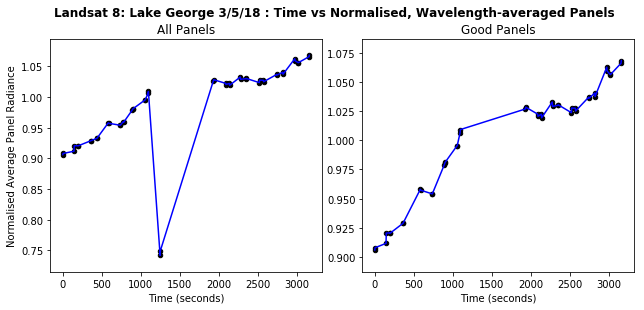

In [20]:
#
# Create a mask to avoid wavelengths where atmospheric transmission is
# close to zero: 1350-1480nm, 1801-1966nm and >2350nm
#
mask1 = good_panel_mean.where(np.logical_or(good_panel_mean.index<1350, good_panel_mean.index>1480))
mask2 = mask1.where(np.logical_or(mask1.index<1801, mask1.index>1966))

# 1.
mean_panel_masked = mask2.where(np.logical_or(mask2.index<2350, mask2.index>2500))

# 2.
good_norm_panels_masked = good_panel_spec.div(mean_panel_masked, axis=0)
all_norm_panels_masked = all_panel_spec.div(mean_panel_masked, axis=0)

# 3.
good_averages_masked = good_norm_panels_masked.mean(axis=0)
all_averages_masked = all_norm_panels_masked.mean(axis=0)

# 4.
gpt['Normalised_Averaged_Panels']=good_averages_masked.values
gpta['Normalised_Averaged_Panels']=all_averages_masked.values

# 5.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9.5, 4.5))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number+': Time vs Normalised, Wavelength-averaged Panels', fontweight='bold')
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

gpta.plot.scatter(x='date_saved', y='Normalised_Averaged_Panels', title='All Panels', color='black', ax=axes[0])
gpta.plot.line(x='date_saved', y='Normalised_Averaged_Panels', ax=axes[0], style='b', legend=False)
axes[0].set_ylabel("Normalised Average Panel Radiance")
axes[0].set_xlabel("Time (seconds)")

gpt.plot.scatter(x='date_saved', y='Normalised_Averaged_Panels', title='Good Panels', color='black', ax=axes[1])
gpt.plot.line(x='date_saved', y='Normalised_Averaged_Panels', ax=axes[1], style='b', legend=False)
axes[1].set_ylabel("")
axes[1].set_xlabel("Time (seconds)")

plt.savefig(output+'Fig06_TimevsAvgPanels.png')

# Figure X7

### Comparison plot between expected insolation curve and normalised, averaged panels

### Currently, this plot is not used.

In [21]:
#good_panel_spec.sum(axis=0)
#gpt['sum']=good_panel_spec.sum(axis=0).values
#
#ax2 = gpt.plot.scatter(x='date_saved', y='sum', color='black')
#gpt.plot.line(x='date_saved', y='sum', ax=ax2, style='b', legend=False)
#plt.figtext(0.12, 0.9, sat_name+": "+field_site+" "+field_date+" "+site_number+': Time vs Wavelength-summed Panels', fontweight='bold')
#
##
## The Following dataframe assumes 26/3/2018, where meridian is at 02:07:44 (UTC) and
## that t=0 is 00:12:58, which is the UTC date stamp of the first panel reading. This dataframe
## then gives the Insolation values, as a function of seconds.
##
#sdf_dst = pd.DataFrame([[-314.0, 0.9544765503230449], [136.0, 0.960635398038314], [586.0, 0.9662590390482365],
#                        [1036.0, 0.9713789520297165], [1486.0, 0.9760229720710379], [1936.0, 0.9802156732739963],
#                        [2386.0, 0.9839786952371856], [2836.0, 0.9873310215393157]], columns=['Time', 'Insolation'])
##
## The following plot shows the same increase in panel readins, as above, but this time, two lines for
## Insolation are plotted. The blue line shows a scaled Insolation curve. The data *should* fit this curve,
## but they do not, without re-aligning the y-axis, as shown in the orange curve. The orange curve is a good
## fit to the data, but it no longer follows the Insolation curve for the time of day.
##
## The reason for this discrepancy may be because the atmospheric absorption is not taken into account. If it
## were, then this should have the effect of steepening the Insolation curve as there is more atmospheric
## absorption when the Sun is lower in the sky (earlier in the day).
##
#sdf_dst_fixed = sdf_dst.copy()
#
#sdf_dst['Insolation']*=248
#sdf_dst.plot.line(x='Time', y='Insolation', ax=ax2)
#plt.savefig(output+'Fig07_TimevsAvgPanelsInsolation.png')

### Define the K-factor

This reads a standard file with a response curve for the detector, given an ideally white surface.<BR>
Then "k_f" is defined for the K-factor.

In [22]:
def k_factor(panel_dir, in_panel):
    k_f = pd.read_csv(panel_dir + in_panel, skiprows=5, delim_whitespace=True)
    # Set index to wavelength
    k_f.set_index("Wavelength", inplace = True) 
    
    return k_f

k_f = k_factor(panel_dir, in_panel)

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [23]:
gps_new_name = 'radiance'+str(firstGoodLine)+"-"+str(firstGoodPanelSpec)
ggs_new_name = 'radiance'+str(firstGoodLine)+"-"+str(firstGoodGroundSpec)

good_panel_spec.rename(columns={'radiance': gps_new_name}, inplace=True)
good_grounds_spec.rename(columns={'radiance': ggs_new_name}, inplace=True)


### Create dataframe with Reflectances

Loop through each Line with spectral data:
<OL>
    <LI>Make an average of all the panel spectra within the Line (line_avg_panel).</LI>
    <LI>For each ground spectrum within the Line, divide by the average panel spectrum (refl_temp)</LI>
    <LI>Multiply each normalised ground spectrum my the K-factor to create reflectances dataframe (line_refls)</LI>
</OL>

Finally, combine each dataframe for reflectances within a line into a single dataframe (all_refls)

In [24]:
frames = []
for j in good_panels.Line.unique():
    
    # 1.
    line_name_pans = [col for col in good_panel_spec.columns if 'radiance'+str(j)+'-' in col]
    
    tmplist = []
    for i in line_name_pans:
        temp = good_panel_spec[i]
        tmplist.append(temp)
    
    tmp_df = pd.concat(tmplist, axis=1)
    line_avg_panel = tmp_df.mean(axis=1)
    
    # 2.
    line_name_grounds = [col for col in good_grounds_spec.columns if 'radiance'+str(j)+'-' in col]
    
    tmplist = []
    for i in line_name_grounds:
        temp = good_grounds_spec[i]
        tmplist.append(temp)
    
    tmp_df = pd.concat(tmplist, axis=1)
    refl_tmp = tmp_df.div(line_avg_panel, axis=0)
    
    # 3.
    line_refls = pd.np.multiply(refl_tmp, k_f)
    
    frames.append(line_refls)

all_refls = pd.concat(frames, axis=1)

# Figure 7

### Plot all ground reflectances in black, plus the Line-averaged reflectances in colour

The Line-averaged reflectances are shown in order to identify any outlying lines that<BR>

might have been caused by bad panel spectra (for example).

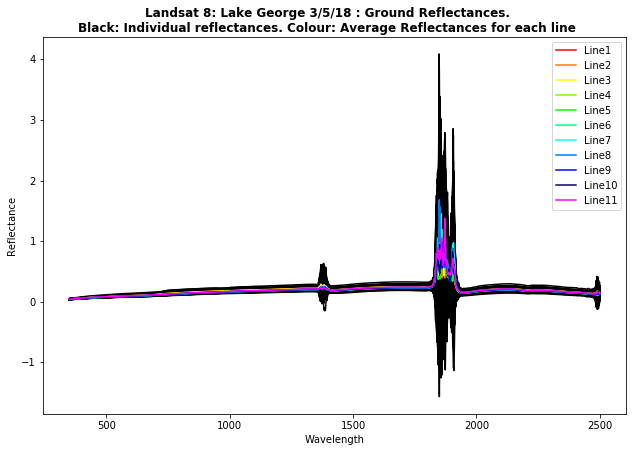

In [25]:
fig, axy = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 6.5))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number+': Ground Reflectances.\nBlack: Individual reflectances. Colour: Average Reflectances for each line', fontweight='bold')
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)
axy.set_ylabel("Reflectance")

all_refls.plot(legend=False, ax=axy, color='k')

colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

for i in good_panels.Line.unique():
    rad_name = 'radiance'+str(i)
    line = all_refls.filter(like=rad_name).mean(axis=1)
    line.plot(ax=axy, color=colpac[i], legend=True, label='Line'+str(i))

axy.set_ylabel("Reflectance")

plt.savefig(output+'Fig07_Reflectances.png')

### Read in the spectral responses for each band

In [26]:
def get_spectrum_curve(f_name):
    band_n = dict() 
    key = list()
    wavelength = np.array([], dtype='float64') 
    response = np.array([], dtype='float64') 
    with open(f_name, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ', skipinitialspace=True)
        for row in csv_reader:
            if row[0].lower().find('band') >= 0:
                key.append(row[0].lower()+row[1])
                if wavelength.shape[0] > 0:
                    spectrum_curve = np.vstack([wavelength, response]).T
                    band_n.update({key[len(key)-2]: spectrum_curve})
                    wavelength = np.array([], dtype='float64') 
                    response = np.array([], dtype='float64') 
            else:
                wavelength = np.append(wavelength, float(row[0]))
                response = np.append(response, float(row[1]))
    spectrum_curve = np.vstack([wavelength, response]).T
    band_n.update({key[len(key)-1]: spectrum_curve})
    wavelength = np.array([], dtype='float64') 
    response = np.array([], dtype='float64') 
    return band_n 

### Create weighted-average of spectrum for each band

In [27]:
def field_int_curve(field_data, band):
    result = np.zeros(len(band))
    i = 0
    for b in band:
        spectrum_curve = band[b]
        dom_a = max(min(spectrum_curve[:, 0]), min(field_data[:, 0]))
        dom_b = min(max(spectrum_curve[:, 0]), max(field_data[:, 0]))
        source_x = field_data[:, 1][np.where((field_data[:, 0] >= dom_a) & 
                (field_data[:, 0] <= dom_b))]
        source_y = spectrum_curve[:, 1][np.where((spectrum_curve[:, 0] >= dom_a) & 
            (spectrum_curve[:, 0] <= dom_b))]
        result[i] = sum(source_x*source_y)/sum(source_y)
        i += 1
    return result

### Apply weighted band responses to all reflectances

In [28]:
f_name = sat_resp['lsat8']
band = get_spectrum_curve(f_name)
result = []
field_data = all_refls
wave_length = np.array(all_refls.index, dtype='float64')
for col in field_data.columns:
    source_x = np.vstack([wave_length, np.array(field_data[col], dtype='float64')]).T
    result.append(field_int_curve(source_x, band))
result_df = pd.DataFrame(result)
result_df.columns = list(band.keys())


### Reformat band reflectances and apply to dataframe "ground_bands"

In [29]:
gg = good_grounds[(good_grounds['Wavelength']==350)]
gg.reset_index(drop=True, inplace=True)

catty = pd.concat([gg,result_df], axis=1)
ground_bands = catty.drop(['Wavelength', 'radiance'], axis=1)

# Figure 8

### Plot band reflectances

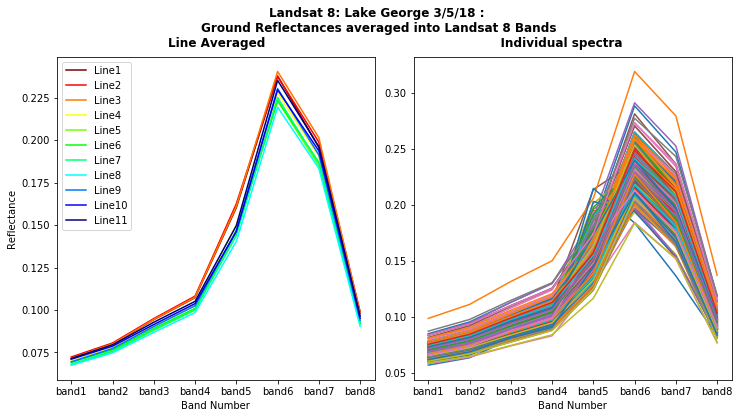

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11.5, 6.5))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number+': \nGround Reflectances averaged into '+sat_name+' Bands\n        Line Averaged                                                         Individual spectra', fontweight='bold')
axes[0].set_ylabel("Reflectance")
axes[0].set_xlabel("Band Number")
axes[1].set_xlabel("Band Number")
axes[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
axes[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.tight_layout(pad=5.5, w_pad=1.0, h_pad=1.0)

d=pd.DataFrame([[[ground_bands[j][(ground_bands['Line']==i)].mean()] for j in list(band.keys())] for i in ground_bands.Line.unique()])
for i in d.columns:
    d[i] = d[i].str.get(0)
    d.rename(columns={i: 'band'+str(i+1)}, inplace=True)
for i in d.index:
    d.rename(index={i: 'Line'+str(i+1)}, inplace=True)

d.T.plot(legend=True, ax=axes[0], color=colpac)

result_df.T.plot(legend=False, ax=axes[1])

plt.savefig(output+'Fig08_BandReflectances.png')

### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [31]:
def solar_angle(row):

    loc = coord.EarthLocation(lon=row['Longitude'] * u.deg,
                              lat=row['Latitude'] * u.deg)
    #timy0 = timei.to_pydatetime()
    timy = Time(row['date_saved'], format='datetime')
    
    altaz = coord.AltAz(location=loc, obstime=timy)
    sun = coord.get_sun(timy)

    return sun.transform_to(altaz).zen.degree

ground_bands['Solar_angle'] = ground_bands.apply(solar_angle, axis=1)

### Print out time stamp and coordinate extent

The time stamp and Lat/Long extents are required to calculate the BRDF correction, used below.

In order to calculate the BRF correction, the following method is used:

<OL>
    <LI>Run the print statements in the cell below.</LI>
    <LI>Copy and paste the output into a VDI terminal window</LI>
    <LI>Copy and paste the resultant VDI output into the BRDF calculation cell, writing over the similar text.</LI>
</OL>

NOTE: This works assuming that the BRDF code is in the directory /home/547/aw3463


In [32]:
print("sed -i \"34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('",ground_bands['date_saved'][0],"'))/\" /home/547/aw3463/brdf/retrieve_brdf.py", sep='')
print("sed -i \"37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(",ground_bands['Longitude'].min(),", ", ground_bands['Latitude'].min(),", ",
      ground_bands['Longitude'].max(),", ", ground_bands['Latitude'].max(),")]})/\" /home/547/aw3463/brdf/retrieve_brdf.py", sep='')
print("python retrieve_brdf.py > temp.txt ; awk -f format.awk temp.txt")
print("")

sed -i "34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('2018-05-03 00:07:24'))/" /home/547/aw3463/brdf/retrieve_brdf.py
sed -i "37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(149.46139333333332, -35.093115, 149.46263, -35.09214166666667)]})/" /home/547/aw3463/brdf/retrieve_brdf.py
python retrieve_brdf.py > temp.txt ; awk -f format.awk temp.txt



### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [33]:
hb = 2 # set to emulate spherical crowns that are separated from the
br = 1 # ground by half their diameter

pib = math.pi/180 # convert from degrees to radians

n_factor = 1

def ReadAndCalc():
    #
    # Create pandas dataframe "brdf_df" which contains the BRDF values
    # for six LS8 bands
    #
    brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.08009322916666667, 0.020404166666666668, 0.012672395833333334],
                          ['band2', 0.08009322916666667, 0.020404166666666668, 0.012672395833333334],
                          ['band3', 0.11958697916666668, 0.040722395833333334, 0.019657291666666667],
                          ['band4', 0.13484114583333334, 0.04903385416666667, 0.02112291666666667],
                          ['band5', 0.25205, 0.14025364583333333, 0.026425],
                          ['band6', 0.32047552083333336, 0.16920885416666667, 0.03346458333333333],
                          ['band7', 0.23522083333333335, 0.08867760416666667, 0.033071875],
                         ])
   
    brdf_df = pd.DataFrame(data=brdf_data[1:,1:],
                  index=brdf_data[1:,0],
                  columns=brdf_data[0,1:])
    
    ground_brdf = ground_bands.copy()
    
    for i in ground_bands.index:
        for j in brdf_df.index:
            norm_1 = float(brdf_df.loc[j,'brdf1'])/float(brdf_df.loc[j,'brdf0'])
            norm_2 = float(brdf_df.loc[j,'brdf2'])/float(brdf_df.loc[j,'brdf0'])
            solar_angle = ground_bands.loc[i,'Solar_angle']
            rland = ground_bands.loc[i,j]
    
            if n_factor == 0:
                fnn = 1
            else:
                fnn = RL_brdf(45*pib, 0, 0, hb, br, 1, norm_1, norm_2)

            solar = solar_angle*pib

            ann = RL_brdf(solar, 0, 0, hb, br, 1, norm_1, norm_2)
            ref = rland * fnn / ann
            ground_brdf.loc[i,j] = ref
            #print(i,j,rland, ref)
    return ground_brdf
            
def RL_brdf(solar, view, ra, hb, br, brdf0, brdf1, brdf2):
    cossolar = math.cos(solar)
    cosvia = math.cos(view)
    cosra = math.cos(ra)
    sinsolar = math.sin(solar)
    sinvia = math.sin(view)
    sinra = math.sin(ra)
    
    cosxi = (cossolar * cosvia) + (sinsolar * sinvia * cosra) # (43)
    
    if cosxi >= 1:
        cosxi = 1
    
    xi = math.acos(cosxi)
    
    rs_thick = (((((math.pi/2) - xi) * math.cos(xi)) + math.sin(xi)) / (cossolar \
                    + cosvia)) - (math.pi/4)  # (38)
    
    tansolar = sinsolar / cossolar
    tanvia = sinvia / cosvia
    theta_new_v = math.atan(br * tanvia)      # (44)
    theta_new_s = math.atan(br * tansolar)    # (44)
    
    cosxi = (math.cos(theta_new_s) * math.cos(theta_new_v)) + (math.sin(theta_new_s) \
             * math.sin(theta_new_v) * cosra) # (43)
    
    if cosxi >= 1:
        cosxi = 1
    
    secsolar = 1 / math.cos(theta_new_s)
    secvia = 1 / math.cos(theta_new_v)
    
    d_li2 = abs(math.tan(theta_new_s)**2 + math.tan(theta_new_v)**2 - (2 * \
                math.tan(theta_new_s)*math.tan(theta_new_v)*cosra)) # (42)**2
    
    x_li = math.tan(theta_new_s) * math.tan(theta_new_v) * sinra
    cosl = hb * math.sqrt(d_li2 + x_li**2) / (secsolar + secvia) # (41)
    
    if cosl >= 1:
        o_li = 0
    else:
        l_li=math.acos(cosl)
        o_li = (l_li - (math.sin(l_li) * math.cos(l_li))) * (secsolar + secvia) \
                / math.pi     # (40)
    
    li_sparse = o_li - (secsolar + secvia) + (0.5 * (1 + cosxi) * secsolar \
                * secvia)  # (39)
    
    rl_brdf = brdf0 + (brdf1 * rs_thick) + (brdf2 * li_sparse)  # (37)
    return rl_brdf

ground_brdf = ReadAndCalc()

### Choose between Landsat 8 and Sentinel satellite data

In the last two lines, swap "ls8_bands" and "senti_bands" for the appropriate satellite overpass.

In [34]:
band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',9,11,12]
ls8_bands = [1,2,3,4,5,6,7,8]

band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]


# Figure 9

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

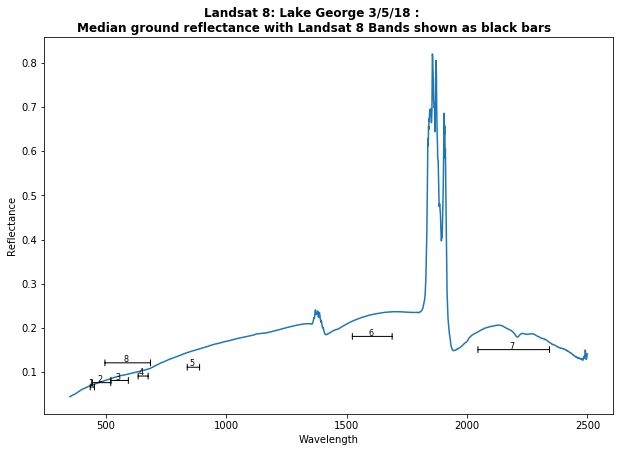

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 6.5))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number+': \nMedian ground reflectance with '+sat_name+' Bands shown as black bars', fontweight='bold')
axes.set_ylabel("Reflectance")
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

med = all_refls.median(axis=1)
all_refls['Median'] = med
all_refls.plot(y='Median', ax=axes, legend=False)

if sat_name == 'Landsat 8': 
    y_cord = [0.065, 0.075, 0.08, 0.09, 0.11, 0.18, 0.15, 0.12]
elif sat_name == 'Sentinel':
    y_cord = [0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.17, 0.15]
else:
    print("Incorrect Satellite name - must be one of Landsat 8 or Sentinel")
    
for i in range(len(band_min)):
    plt.annotate('', xy = (band_min[i], y_cord[i]),  xycoords = 'data', \
        xytext = (band_max[i], y_cord[i]), textcoords = 'data',\
        arrowprops=dict(edgecolor='black', arrowstyle = '|-|, widthA=0.3, widthB=0.3'))
    plt.text((band_max[i]+band_min[i]-35)/2, y_cord[i]+0.002, i+1, fontsize=8)

plt.savefig(output+'Fig09_BandWavelengths.png')

### Print field data time and Latitude/Longitude extents

The print outputs are used to manually feed the following query cell the right information<BR>
for the field data. Depending on how the field data align with satellite data, the longitude<BR>
and latitude extents may need to be adjusted.

In [36]:
print(ground_bands['date_saved'][0])
print(ground_bands['Latitude'].min(), ground_bands['Latitude'].max(),
      ground_bands['Longitude'].min(), ground_bands['Longitude'].max())


2018-05-03 00:07:24
-35.093115 -35.09214166666667 149.46139333333332 149.46263


### Query Satellite data

Retrieve xarrays for satellite data, based on query area and time.<BR>
sat_array will contain all band data<BR>
sat_rgb only contains the red, green and blue bands.

In [37]:
query = {
         'time': ('2018-03-20', '2018-05-15'),
         'lat': (-35.0930, -35.0921),
         'lon': (149.4613, 149.4627),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
        }
sat_array = dc.load(product='ls8_nbar_albers', **query)
sat_rgb = dc.load(product='ls8_nbar_albers', measurements=['red', 'green', 'blue'], **query)

# Figure 10

### Plot relative locations of field and satellite data

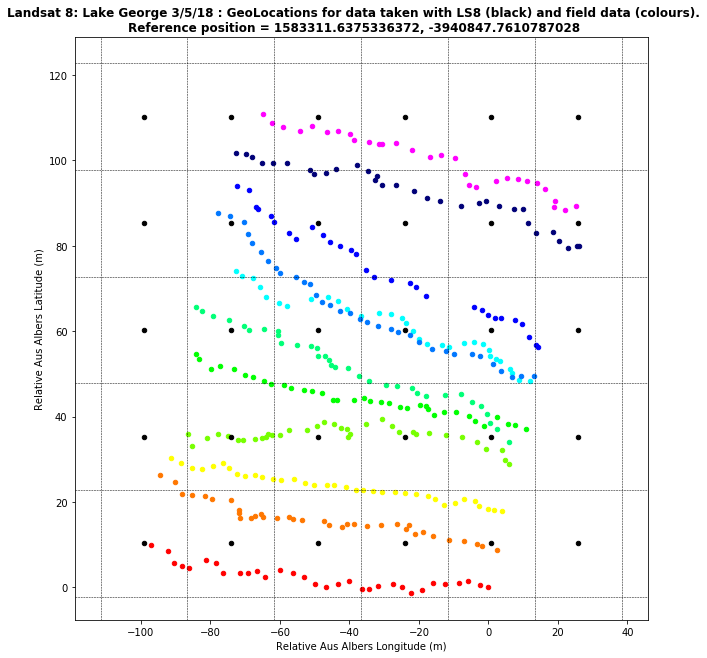

In [38]:
wgs_84 = pyproj.Proj(init='epsg:4326')
aus_albers = pyproj.Proj(init='epsg:3577')

xloc = [pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][i], ground_brdf['Latitude'][i]) for i in range(len(ground_brdf))]

relxloc = [(xloc[i][0]-xloc[0][0], xloc[i][1]-xloc[0][1]) for i in range(len(ground_brdf))]

satloc = [[0 for x in range(2)] for y in range(len(sat_array.x)*(len(sat_array.y)))]
count=0
for i in range(len(sat_array.x)):
    for j in range(len(sat_array.y)):
        satloc[count][0] = float(sat_array.x[i]-xloc[0][0])
        satloc[count][1] = float(sat_array.y[j]-xloc[0][1])
        count+=1
      
satloc_df = pd.DataFrame(satloc)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 9.5))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number+': GeoLocations for data taken with LS8 (black) and field data (colours).\nReference position = '+str(xloc[0][0])+', '+str(xloc[0][1]), fontweight='bold')
plt.tight_layout(pad=4.0, w_pad=1.0, h_pad=1.0)

def gridlines(satloc_df):
    axes.axhline(satloc_df[1].unique()[0]+12.5, linestyle='--', color='black', linewidth=0.5)
    for i in range(len(satloc_df[1].unique())):
        axes.axhline(satloc_df[1].unique()[0]-(12.5+(25*i)), linestyle='--', color='black', linewidth=0.5)

    axes.axvline(satloc_df[0].unique()[0]-12.5, linestyle='--', color='black', linewidth=0.5)
    for i in range(len(satloc_df[0].unique())):
        axes.axvline(satloc_df[0].unique()[0]+(12.5+(25*i)), linestyle='--', color='black', linewidth=0.5)


rr = pd.DataFrame(relxloc)

ground_brdf_XY = pd.concat([ground_brdf, rr], axis=1)
ground_brdf_XY.rename(columns={0: 'RelX', 1: 'RelY'}, inplace=True)

for i in ground_brdf_XY.Line.unique():
    ground_brdf_XY[(ground_brdf_XY['Line']==i)].plot.scatter('RelX', 'RelY', ax=axes, color=colpac[i])

satloc_df.plot.scatter(0,1, ax=axes, color='black', )

axes.set_xlabel("Relative Aus Albers Longitude (m)")
axes.set_ylabel("Relative Aus Albers Latitude (m)")

gridlines(satloc_df)

plt.savefig(output+'Fig10_SatFieldLocations.png')

### Create Australian albers columns for ground_brdf (not used)

In [39]:
for i in range(len(ground_brdf)):
    ground_brdf['Xalbers'], ground_brdf['Yalbers'] = pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][i], ground_brdf['Latitude'][i])
    
print(ground_brdf['Xalbers'][4], ground_brdf['Yalbers'][4])

pyproj.transform(wgs_84, aus_albers, ground_brdf['Longitude'][4], ground_brdf['Latitude'][4])

1583246.7124192906 -3940736.8499963083


(1583299.046842748, -3940846.964919033)

### Create Field RGB xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [40]:
field_rgb = sat_rgb.astype(float)

for i in range(len(sat_rgb.x)):
    for j in range(len(sat_rgb.y)):
        count = 0
        cum2, cum3, cum4 = 0, 0, 0
        for k in range(len(xloc)):
            if (sat_rgb.x[i]-12.5 < xloc[k][0] < sat_rgb.x[i]+12.5) and (sat_rgb.y[j]-12.5 < xloc[k][1] < sat_rgb.y[j]+12.5):
                cum2 = cum2+ground_brdf.iloc[k]['band2']
                cum3 = cum3+ground_brdf.iloc[k]['band3']
                cum4 = cum4+ground_brdf.iloc[k]['band4']
                count=count+1
        
        if count<10:
            field_rgb.blue[0][j][i] = np.nan
            field_rgb.green[0][j][i] = np.nan
            field_rgb.red[0][j][i] = np.nan          
        else:
            field_rgb.blue[0][j][i] = cum2/count
            field_rgb.green[0][j][i] = cum3/count
            field_rgb.red[0][j][i] = cum4/count

# Figure 11

### Plot RGB array for Satellite data

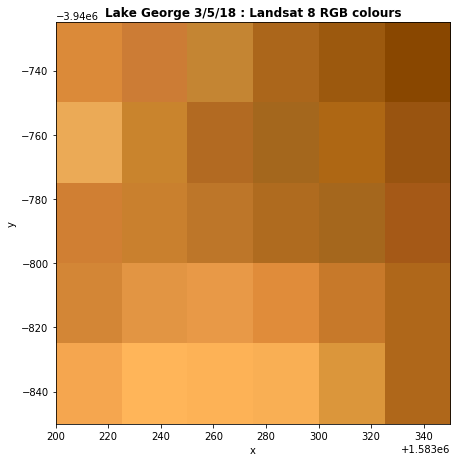

In [41]:
fake_saturation = 10000
srgb = sat_rgb.to_array(dim='color')
srgb = srgb.transpose(*(srgb.dims[1:]+srgb.dims[:1]))  # make 'color' the last dimension
srgb = srgb.where((srgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
srgb /= fake_saturation  # scale to [0, 1] range for imshow

srgb.plot.imshow(x=sat_rgb.crs.dimensions[1], y=sat_rgb.crs.dimensions[0],
                col='time', aspect=1, figsize=(6.5, 6.5))
plt.title(field_site+' '+field_date+' '+site_number+': '+sat_name+' RGB colours', fontweight='bold')

plt.savefig(output+'Fig11_LS8_rgb.png')

# Figure 12

### Plot RGB array for Field data

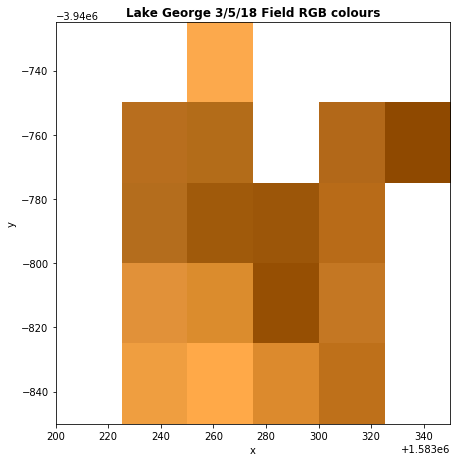

In [42]:
fake_saturation = 1
frgb = field_rgb.to_array(dim='color')
frgb = frgb.transpose(*(frgb.dims[1:]+frgb.dims[:1]))  # make 'color' the last dimension
frgb = frgb.where((frgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
frgb /= fake_saturation  # scale to [0, 1] range for imshow


frgb.plot.imshow(x=field_rgb.crs.dimensions[1], y=field_rgb.crs.dimensions[0],
                col='time', add_colorbar=True, figsize=(6.5, 6.5))
plt.title(field_site+' '+field_date+' '+site_number+'Field RGB colours', fontweight='bold')
plt.savefig(output+'Fig12_Field_rgb.png')

### Test query for Sentinel 2 data (not used)

In [43]:
# dc2 = datacube.Datacube(config='/home/547/aw3463/sentinel2.config')
#
#query = {
#        'lat': (-35.25, -35.35),
#        'lon': (149.05, 149.17),
#        'output_crs': 'EPSG:3577',
#        'resolution': (-10, 10),
#        'time':('2017-10-01', '2018-05-15')
#        }
#
#canberra = dc2.load(product='s2b_ard_granule', **query)
#
#canberra

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [44]:
field_array = sat_array.astype(float)

for i in range(len(sat_array.x)):
    for j in range(len(sat_array.y)):
        count = 0
        cum1, cum2, cum3, cum4, cum5, cum6, cum7 = 0,0,0,0,0,0,0
        for k in range(len(xloc)):
            if (sat_array.x[i]-12.5 < xloc[k][0] < sat_array.x[i]+12.5) and (sat_array.y[j]-12.5 < xloc[k][1] < sat_array.y[j]+12.5):
                cum1 = cum1+ground_brdf.iloc[k]['band1']
                cum2 = cum2+ground_brdf.iloc[k]['band2']
                cum3 = cum3+ground_brdf.iloc[k]['band3']
                cum4 = cum4+ground_brdf.iloc[k]['band4']
                cum5 = cum5+ground_brdf.iloc[k]['band5']
                cum6 = cum6+ground_brdf.iloc[k]['band6']
                cum7 = cum7+ground_brdf.iloc[k]['band7']
                count=count+1
        if count<10:
            field_array.coastal_aerosol[0][j][i] = np.nan
            field_array.blue[0][j][i] = np.nan
            field_array.green[0][j][i] = np.nan
            field_array.red[0][j][i] = np.nan
            field_array.nir[0][j][i] = np.nan
            field_array.swir1[0][j][i] = np.nan
            field_array.swir2[0][j][i] = np.nan
        else:
            field_array.coastal_aerosol[0][j][i] = cum1/count            
            field_array.blue[0][j][i] = cum2/count
            field_array.green[0][j][i] = cum3/count
            field_array.red[0][j][i] = cum4/count
            field_array.nir[0][j][i] = cum5/count
            field_array.swir1[0][j][i] = cum6/count
            field_array.swir2[0][j][i] = cum7/count

# Figure 13

### Plot ratio arrays for each band

Each panel shows the ratio of satellite/field data * 100. Therefore, the intensity axis gives<BR>
a percentage of the satellite data, as a function of the field data, where perfectly matching<BR>
    data should show 100%.

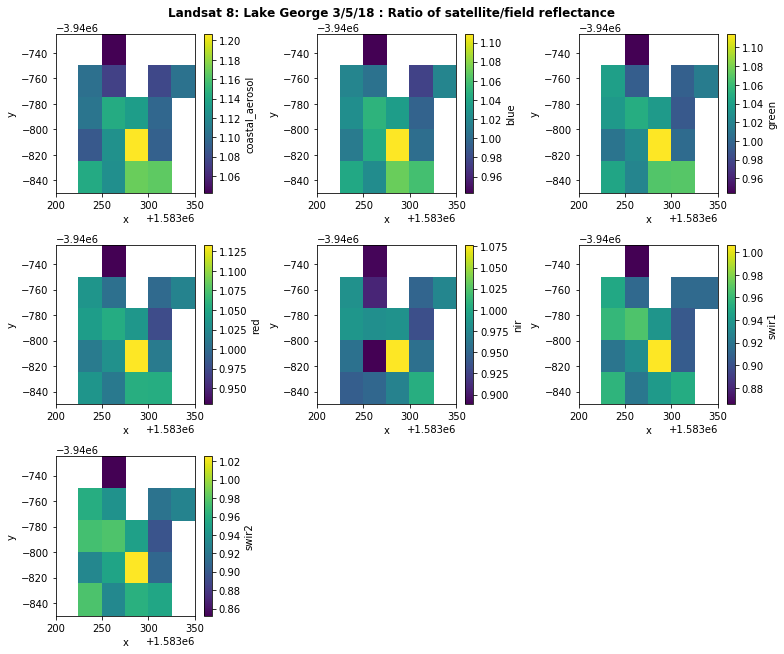

In [45]:
newarr = (sat_array/10000)/field_array
newarr.reset_index('time', drop=True, inplace=True)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(11.5, 9.5))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number+': Ratio of satellite/field reflectance', fontweight='bold')

newarr.coastal_aerosol.plot(ax=axes[0,0])
newarr.blue.plot(ax=axes[0,1])
newarr.green.plot(ax=axes[0,2])
newarr.red.plot(ax=axes[1,0])
newarr.nir.plot(ax=axes[1,1])
newarr.swir1.plot(ax=axes[1,2])
newarr.swir2.plot(ax=axes[2,0])
plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)

axes[2,1].axis('off')
axes[2,2].axis('off')
plt.savefig(output+'Fig13_RatioSatOverFieldData.png')

### Create a statistics dataframe, comparing satellite and field data

In [46]:
data_array = np.array([['','LS8_mean','LS8_SD', 'Field_mean', 'Field_SD'],
                ['Band1', float(sat_array.coastal_aerosol.mean()/10000), float(sat_array.coastal_aerosol.std()/10000), float(ground_bands['band1'].mean()), float(ground_bands['band1'].std())],
                ['Band2', float(sat_array.blue.mean()/10000), float(sat_array.blue.std()/10000), float(ground_bands['band2'].mean()), float(ground_bands['band2'].std())],
                ['Band3', float(sat_array.green.mean()/10000), float(sat_array.green.std()/10000), float(ground_bands['band3'].mean()), float(ground_bands['band3'].std())],
                ['Band4', float(sat_array.red.mean()/10000), float(sat_array.red.std()/10000), float(ground_bands['band4'].mean()), float(ground_bands['band4'].std())],
                ['Band5', float(sat_array.nir.mean()/10000), float(sat_array.nir.std()/10000), float(ground_bands['band5'].mean()), float(ground_bands['band5'].std())],
                ['Band6', float(sat_array.swir1.mean()/10000), float(sat_array.swir1.std()/10000), float(ground_bands['band6'].mean()), float(ground_bands['band6'].std())],
                ['Band7', float(sat_array.swir2.mean()/10000), float(sat_array.swir2.std()/10000), float(ground_bands['band7'].mean()), float(ground_bands['band7'].std())],
                ])
                
stat_df = pd.DataFrame(data=data_array[1:,1:],
                  index=data_array[1:,0],
                  columns=data_array[0,1:])

stat_df['LS8_SD/mean (%)'] = 100*stat_df['LS8_SD'].astype(float)/stat_df['LS8_mean'].astype(float)
stat_df['Field_SD/mean (%)'] = 100*stat_df['Field_SD'].astype(float)/stat_df['Field_mean'].astype(float)
stat_df['LS8/Field'] = stat_df['LS8_mean'].astype(float)/stat_df['Field_mean'].astype(float) 

stat_df
#stat_df['LS8/Field'].std()/stat_df['LS8/Field'].mean()*100

,LS8_mean,LS8_SD,Field_mean,Field_SD,LS8_SD/mean (%),Field_SD/mean (%),LS8/Field
Band1,0.08143333333333334,0.0037432012443302533,0.06999612010855294,0.005021777953085901,4.596645,7.174366,1.163398
Band2,0.08306333333333334,0.0041985301660885516,0.07784257080013193,0.005838735054739329,5.054613,7.500697,1.067068
Band3,0.09728333333333333,0.0052086519902519455,0.09108995294962764,0.00707004585002945,5.354105,7.761609,1.067992
Band4,0.11022,0.005685091614623872,0.10341774248507497,0.008380724960461904,5.157949,8.103759,1.065775
Band5,0.14629333333333333,0.007564034784572465,0.1506070060597599,0.015863641257058733,5.170458,10.533136,0.971358
Band6,0.21909,0.008500092156363168,0.23018630721196007,0.017888533080705215,3.879726,7.771328,0.951794
Band7,0.18700333333333333,0.008512010468874096,0.1918362100609508,0.017505495902231757,4.551796,9.125230,0.974807


### Convert all statistics entries to float

In [47]:
fstat_df = stat_df.astype(float)

# Figure 14

### Plot comparison spectra of ALL satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the field data, based on the standard deviation of the pixels<BR>
    within the field.

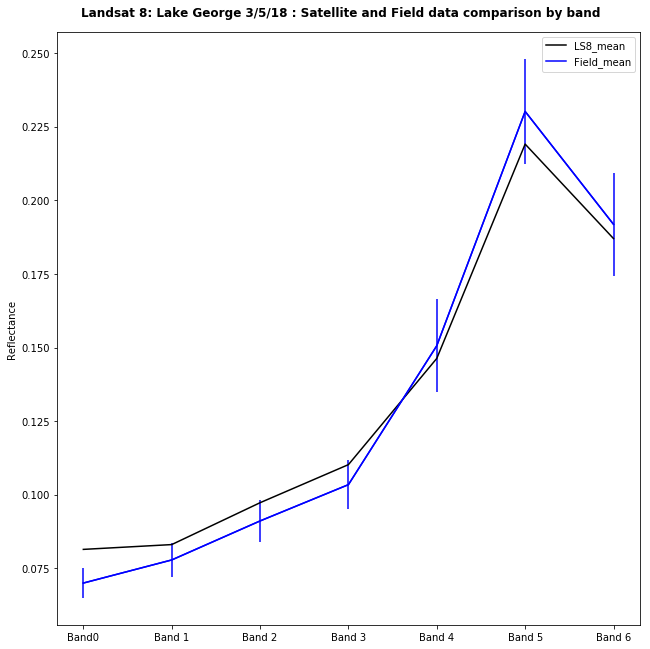

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 9.5))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number+': Satellite and Field data comparison by band', fontweight='bold')
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

fstat_df.plot(x=fstat_df.index, y='LS8_mean', ax=axes, color='black')
fstat_df.plot(y='Field_mean', ax=axes, color='blue')
axes.set_ylabel('Reflectance')
plt.errorbar(x=fstat_df.index, y=fstat_df['Field_mean'], yerr=fstat_df['Field_SD'], color='blue')
axes.set_xticklabels(['Band0','Band 1','Band 2','Band 3','Band 4','Band 5','Band 6', 'Band 7'])
plt.savefig(output+'Fig14_LS8FieldBandCompare.png')

# Figure 15

### Plot comparison spectra of INNER satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the field data, based on the standard deviation of the pixels
within the field.

Only inner pixels are chosen to compare, where there are many field spectra for each satellite<BR>
    pixel. For example, using [2:4,2:4] will choose four pixels between coordinates (2,2) and (3,3),<BR>
    inclusive, from the top-left corner.

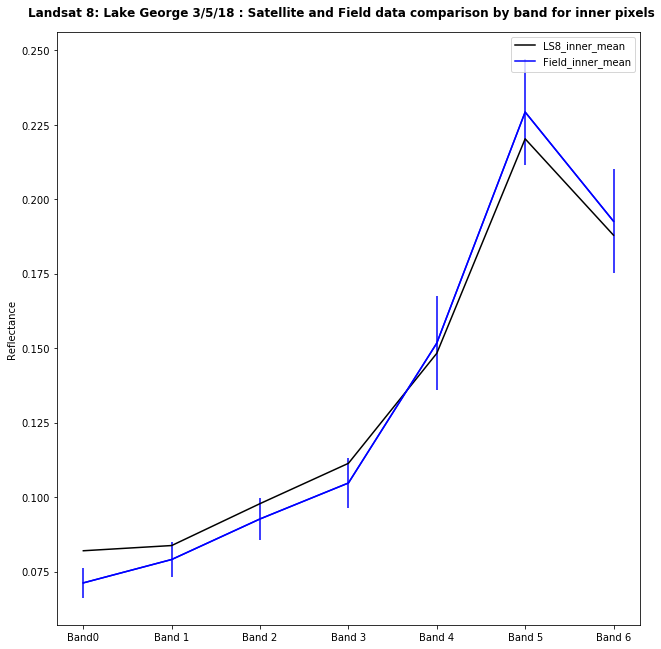

In [49]:
inner_array = np.array([['', 'LS8_inner_mean', 'Field_inner_mean'],
                        ['Band1', float(sat_array.coastal_aerosol[0][2:4,2:4].mean()/10000), float(field_array.coastal_aerosol[0][2:4,2:4].mean())],
                        ['Band2', float(sat_array.blue[0][2:4,2:4].mean()/10000), float(field_array.blue[0][2:4,2:4].mean())],
                        ['Band3', float(sat_array.green[0][2:4,2:4].mean()/10000), float(field_array.green[0][2:4,2:4].mean())],
                        ['Band4', float(sat_array.red[0][2:4,2:4].mean()/10000), float(field_array.red[0][2:4,2:4].mean())],
                        ['Band5', float(sat_array.nir[0][2:4,2:4].mean()/10000), float(field_array.nir[0][2:4,2:4].mean())],
                        ['Band6', float(sat_array.swir1[0][2:4,2:4].mean()/10000), float(field_array.swir1[0][2:4,2:4].mean())],
                        ['Band7', float(sat_array.swir2[0][2:4,2:4].mean()/10000), float(field_array.swir2[0][2:4,2:4].mean())],
                       ])

inner_df = pd.DataFrame(data=inner_array[1:,1:],
                  index=inner_array[1:,0],
                  columns=inner_array[0,1:])

inner_df['Field_SD'] = fstat_df['Field_SD']

finner_df = inner_df.astype(float)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 9.5))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number+': Satellite and Field data comparison by band for inner pixels', fontweight='bold')
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

finner_df.plot(x=finner_df.index, y='LS8_inner_mean', ax=axes, color='black')
finner_df.plot(y='Field_inner_mean', ax=axes, color='blue')
axes.set_ylabel('Reflectance')
plt.errorbar(x=finner_df.index, y=finner_df['Field_inner_mean'], yerr=finner_df['Field_SD'], color='blue')
axes.set_xticklabels(['Band0','Band 1','Band 2','Band 3','Band 4','Band 5','Band 6', 'Band 7'])
plt.savefig(output+'Fig15_InnerLS8FieldBandCompare.png')

# Figure 16

### Comparison plot of Field and satellite data

Plot shows a pixel-by-pixel comparison of all pixels where field data exists.<BR> 
Different band data are shown in different colours and different symbols.

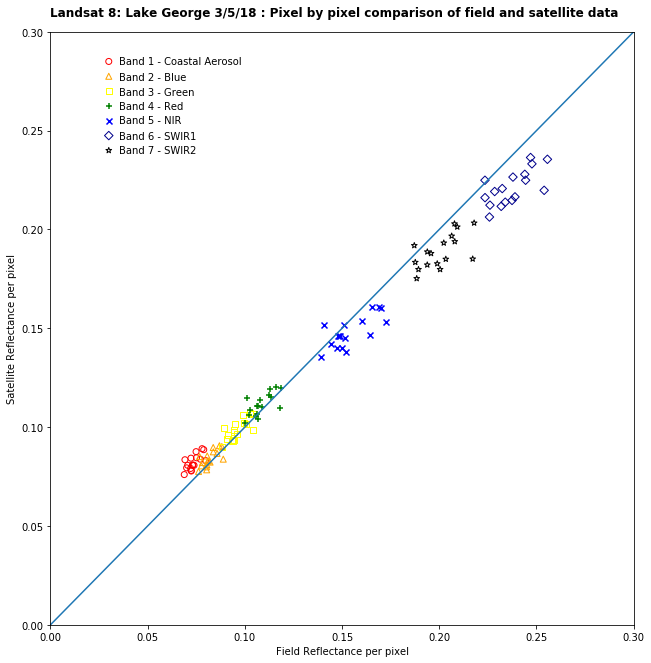

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 9.5))
fig.suptitle(sat_name+': '+field_site+' '+field_date+' '+site_number+': Pixel by pixel comparison of field and satellite data', fontweight='bold')
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

plot_scale = [0.0, 0.3, 0.0, 0.3]
plt.xlim(plot_scale[0], plot_scale[1])
plt.ylim(plot_scale[2], plot_scale[3])
p1, p2 = [-1, 2], [-1, 2]
plt.plot(p1, p2, marker='o')
plt.xlabel('Field Reflectance per pixel')
plt.ylabel('Satellite Reflectance per pixel')

plt.scatter(field_array.coastal_aerosol[0], sat_array.coastal_aerosol[0]/10000, marker='o', facecolors='none', edgecolors='red')
plt.scatter(field_array.blue[0], sat_array.blue[0]/10000, marker='^', facecolors='none', edgecolors='orange')
plt.scatter(field_array.green[0], sat_array.green[0]/10000, marker='s', facecolors='none', edgecolors='yellow')
plt.scatter(field_array.red[0], sat_array.red[0]/10000, marker='+', color='green')
plt.scatter(field_array.nir[0], sat_array.nir[0]/10000, marker='x', color='blue')
plt.scatter(field_array.swir1[0], sat_array.swir1[0]/10000, marker='D', facecolors='none', edgecolors='darkblue')
plt.scatter(field_array.swir2[0], sat_array.swir2[0]/10000, marker='*', facecolors='none', edgecolors='black')

x_stretch = (plot_scale[1]-plot_scale[0])
y_stretch = (plot_scale[3]-plot_scale[2])

plt.scatter((0.1*x_stretch)+plot_scale[0], (0.950*y_stretch)+plot_scale[2], marker='o', facecolors='none', edgecolors='red')
plt.scatter((0.1*x_stretch)+plot_scale[0], (0.925*y_stretch)+plot_scale[2], marker='^', facecolors='none', edgecolors='orange')
plt.scatter((0.1*x_stretch)+plot_scale[0], (0.900*y_stretch)+plot_scale[2], marker='s', facecolors='none', edgecolors='yellow')
plt.scatter((0.1*x_stretch)+plot_scale[0], (0.875*y_stretch)+plot_scale[2], marker='+', color='green')
plt.scatter((0.1*x_stretch)+plot_scale[0], (0.850*y_stretch)+plot_scale[2], marker='x', color='blue')
plt.scatter((0.1*x_stretch)+plot_scale[0], (0.825*y_stretch)+plot_scale[2], marker='D', facecolors='none', edgecolors='darkblue')
plt.scatter((0.1*x_stretch)+plot_scale[0], (0.800*y_stretch)+plot_scale[2], marker='*', facecolors='none', edgecolors='black')

plt.figtext(0.185, 0.895, "Band 1 - Coastal Aerosol")
plt.figtext(0.185, 0.872, "Band 2 - Blue")
plt.figtext(0.185, 0.850, "Band 3 - Green")
plt.figtext(0.185, 0.830, "Band 4 - Red")
plt.figtext(0.185, 0.809, "Band 5 - NIR")
plt.figtext(0.185, 0.786, "Band 6 - SWIR1")
plt.figtext(0.185, 0.766, "Band 7 - SWIR2")
plt.savefig(output+'Fig16_PixelByPixelComparison.png')